<a href="https://colab.research.google.com/github/flow4u/public/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19

Data Source: https://github.com/CSSEGISandData/COVID-19
 
 

To run this notebook: **CTRL + F9**

In [0]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [0]:
#@title
data_sets = ('Confirmed', 'Recovered', 'Deaths')
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-"

for set in data_sets:
  df_temp = pd.read_csv(base_url+set+'.csv')
  df_temp = df_temp.drop(['Lat', 'Long'],axis=1)
  del df_temp['Province/State']
  # not all date columns have the same format, some are mm/d/yy, others mm/dd/yy
  # this will convert first to date, then back to string
  for col in df_temp.columns:
    try:
      col1 = col[:len(col)-2]+'20'+col[-2:]
      col_new = datetime.strptime(col1,'%m/%d/%Y')
      col_new = datetime.strftime(col_new, '%Y-%m-%d')
      df_temp.rename(columns={col: col_new}, inplace=True)
    except:
      pass
  df_temp = df_temp.groupby(['Country/Region']).sum()
  df_temp['Status'] = set
  try:
    df = df.append(df_temp, sort=False)
  except:
    df=df_temp

df = df.reindex(sorted(df.columns), axis=1)  

In [0]:
#@title
europe = ['Austria', 'Belgium', 'Croatia', 'Finland',
       'France', 'Germany','Italy',
       'Spain', 'Sweden','Switzerland',
       'UK']

western = ['Australia', 
           'Austria', 'Belgium', 'Croatia', 'Finland',
           'France', 'Germany','Italy',
           'Spain', 'Sweden','Switzerland', 'UK', 
          'Japan', 'US']

asia = ['Cambodia',
       'Hong Kong',
       'Japan', 'Macau', 'Mainland China', 'Malaysia',
       'Nepal', 'Philippines', 'Singapore', 'South Korea',
       'Sri Lanka', 'Taiwan', 'Thailand',
       'Vietnam']

asia_excl_mainland_china = ['Cambodia',
       'Hong Kong',
       'Japan', 'Macau', 'Malaysia',
       'Nepal', 'Philippines', 'Singapore', 'South Korea',
       'Sri Lanka', 'Taiwan', 'Thailand',
       'Vietnam']


middle_east = ['Afghanistan', 'Algeria', 'Egypt', 'Bahrain','Kuwait','Oman',
       'Iran', 'Iraq', 'Israel',
       'Lebanon', 'Macau',
       'United Arab Emirates']

all_countries = ['Afghanistan', 'Algeria', 'Australia', 'Austria', 'Bahrain', 'Belgium',
       'Cambodia', 'Canada', 'Croatia', 'Egypt', 'Finland', 'France',
       'Germany', 'Hong Kong', 'India', 'Iran', 'Iraq', 'Israel', 'Italy',
       'Japan', 'Kuwait', 'Lebanon', 'Macau', 'Mainland China', 'Malaysia',
       'Nepal', 'Oman', 'Others', 'Philippines', 'Russia', 'Singapore',
       'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan',
       'Thailand', 'UK', 'US', 'United Arab Emirates', 'Vietnam']

for t in df.index.unique():
  if all_countries.count(t) == 0:
    print("Missing: '"+t+ "'")

# df.index.unique()

# Selecting what data to see

In [0]:
#@markdown Select and Press **CTRL + F10** to update the graphs
country_selection = "Europe" #@param ["All", "Not Mainland China", 'Mainland China", "Europe", "Europe + North America + Japan + Australia", "Russia", "Middle-East", "India", "Others", "Asia", "Asia excl Mainland China"] {allow-input: true}
stepsize =  1#@param {type:"integer"}
df2=[]
if country_selection == 'Not Mainland China':
  df2 = df[df.index != 'Mainland China']
elif country_selection == 'Mainland China':
  df2 = df[df.index == 'Mainland China']
elif country_selection == 'Middle-East':
  df2 = df[df.index.isin(middle_east)]
elif country_selection == 'Asia':
  df2 = df[df.index.isin(asia)]
elif country_selection == 'Asia excl Mainland China':
  df2 = df[df.index.isin(asia_excl_mainland_china)]
elif country_selection == 'India':
  df2 = df[df.index == 'India']
elif country_selection == 'Europe':
  df2 = df[df.index.isin(europe)]
elif country_selection == 'Europe + North America + Japan + Australia':
  df2 = df[df.index.isin(western)]
elif country_selection == 'Russia':
  df2 = df[df.index == 'Russia']
elif country_selection == 'Others':
  df2 = df[df.index == 'Others']
else:
  df2 = df
# df2.head()

df_status = df2.groupby(['Status']).sum()

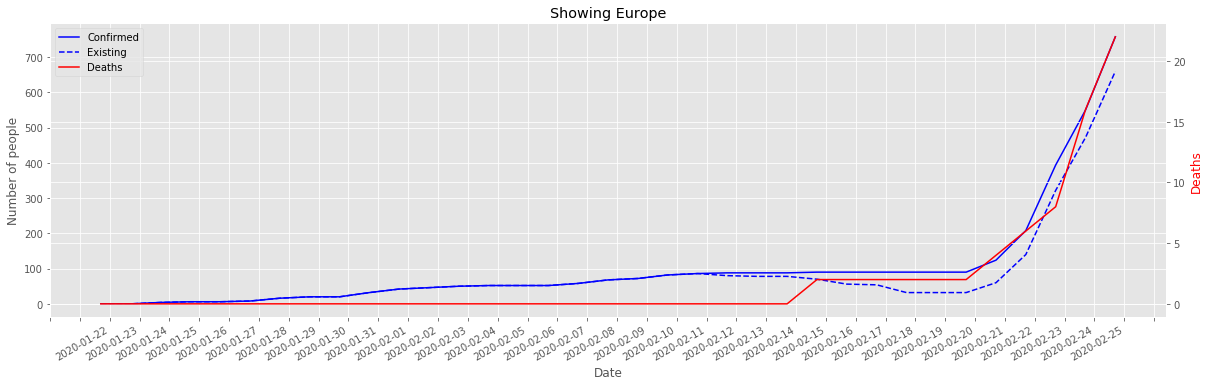

In [71]:
#@title

df_plot = df_status.T.reset_index()
df_plot['Existing'] = df_plot['Confirmed'] - df_plot['Deaths'] - df_plot['Recovered']
plt.style.use('ggplot')
x = df_plot['index']
y1 = df_plot['Confirmed']
y2 = df_plot['Deaths']
y3 = df_plot['Existing']
fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
line1, = ax1.plot(x, y1, 'b-', label = 'Confirmed')
line2, = ax1.plot(x, y3, 'b--', label = 'Existing')
line3, = ax2.plot(x, y2, 'r-', label = 'Deaths')

fig.autofmt_xdate()

# ax1.set_ylim(0,55000)
start, end = ax1.get_xlim()
# stepsize = 5
ax1.xaxis.set_ticks(np.arange(start, end, stepsize))

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of people')
ax2.set_ylabel('Deaths', color='r')


title = 'Showing ' + country_selection
plt.legend(handles=[line1, line2, line3], loc='upper left')
plt.title(title)

plt.show()

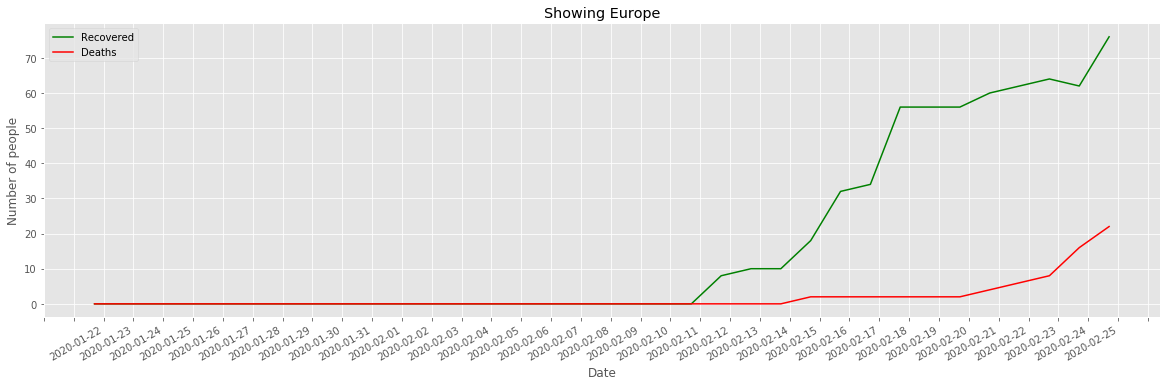

In [72]:
#@title
df_plot = df_status.T.reset_index()

plt.style.use('ggplot')
y11 = 'Recovered'
y21 = 'Deaths'
x = df_plot['index']
y1 = df_plot[y11]
y2 = df_plot[y21]
fig, ax1 = plt.subplots(figsize=(20,6))

fig.autofmt_xdate()

# ax2 = ax1.twinx()
line1, = ax1.plot(x, y1, 'g-', label=y11)
line2, = ax1.plot(x, y2, 'r-', label=y21)

# ax1.set_ylim(0,55000)
start, end = ax1.get_xlim()
# stepsize = 5
ax1.xaxis.set_ticks(np.arange(start, end, stepsize))

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of people')

title = 'Showing ' + country_selection
plt.legend(handles=[line1, line2])
plt.title(title)

plt.show()


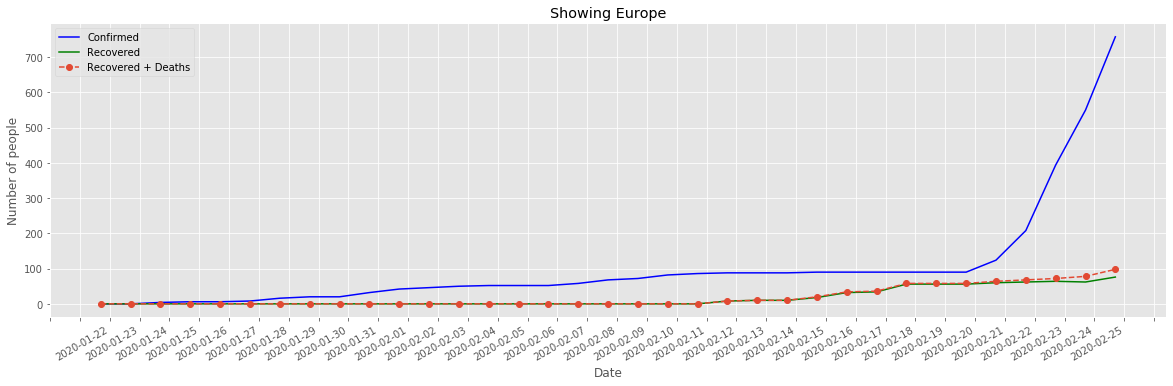

In [73]:
#@title
df_plot = df_status.T.reset_index()
df_plot['Recovered + Deaths'] = df_plot['Recovered'] +df_plot['Deaths']
plt.style.use('ggplot')
y11 = 'Confirmed'
y21 = 'Recovered'
y31 = 'Recovered + Deaths'
x = df_plot['index']
y1 = df_plot[y11]
y2 = df_plot[y21]
y3 = df_plot[y31]
fig, ax1 = plt.subplots(figsize=(20,6))

fig.autofmt_xdate()

# ax2 = ax1.twinx()
line1, = ax1.plot(x, y1, 'b-', label=y11)
line2, = ax1.plot(x, y2, 'g-', label=y21)
line3, = ax1.plot(x, y3, 'o--', label=y31)

# ax1.set_ylim(0,55000)
start, end = ax1.get_xlim()
# stepsize = 5
ax1.xaxis.set_ticks(np.arange(start, end, stepsize))

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of people')

title = 'Showing ' + country_selection
plt.legend(handles=[line1, line2, line3])
plt.title(title)

plt.show()

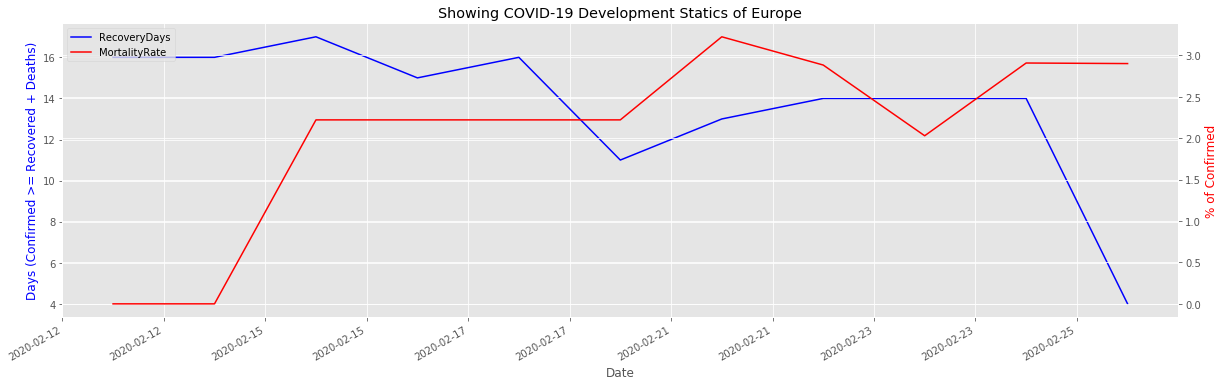

In [74]:
#@title
df_temp2 = df_status.T.reset_index()
date_list=[]
days_list=[]
mortality_rate_list=[]
value_temp = -1
value2_temp = -1
value3_temp = -1
for index, row in df_temp2.iterrows():
  if row['Recovered'] > 0:
    value_lookup = row['Recovered']
    value2_lookup = row['Confirmed']
    value3_lookup = row['Deaths']
    mortality_rate = value3_lookup / value2_lookup * 100
    # mortality_rate_list.append(mortality_rate)
    if(value_temp != value_lookup or value2_temp != value2_lookup or value3_temp != value3_lookup):
      for index2, row2 in df_temp2.iterrows():
        if row2['Confirmed'] >= (value_lookup+value3_lookup):
          date1 = datetime.strptime(row['index'], '%Y-%m-%d')
          date2 = datetime.strptime(row2['index'], '%Y-%m-%d')
          recovery_time = date1-date2
          recovery_time_date = datetime.strftime(date1, '%Y-%m-%d')
          recovery_days = recovery_time.days
          date_list.append(recovery_time_date)
          days_list.append(recovery_days)
          mortality_rate_list.append(mortality_rate)
          break
      value_temp = value_lookup
      value2_temp = value2_lookup
      value3_temp = value3_lookup


df_recovery_time = pd.DataFrame(days_list, index=date_list, columns=['RecoveryDays'])
df_mortality_rate = pd.DataFrame(mortality_rate_list, index=date_list, columns=['MortalityRate'])

plt.style.use('ggplot')
y11 = 'RecoveryDays'
y21 = 'MortalityRate'
x = df_recovery_time.index
y1 = df_recovery_time[y11]
y2 = df_mortality_rate[y21]
fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
marker1 = 'o'
marker2 = 'x'
if df_recovery_time.shape[0] > 1:
  marker1 = ''
  marker2 = ''
line1, = ax1.plot(x, y1, 'b-', label=y11, marker=marker1)
line2, = ax2.plot(x, y2, 'r-', label=y21, marker=marker2)

fig.autofmt_xdate()

# ax1.set_ylim(0,55000)
start, end = ax1.get_xlim()
# stepsize = 5
ax1.xaxis.set_ticks(np.arange(start, end, stepsize))

ax1.set_xlabel('Date')
ax1.set_ylabel('Days (Confirmed >= Recovered + Deaths)', color='b')
ax2.set_ylabel('% of Confirmed', color='r')

title = 'Showing COVID-19 Development Statics of ' + country_selection
plt.legend(handles=[line1,line2], loc='upper left')
plt.title(title)

plt.show()